### Problem Statement
 The primary objective of this project is to develop a regression model that predicts the price
 of an Airbnb listing. Using features such as property type, room type, number of reviews,
 location, and amenities, the model will aim to estimate the price accurately.
 The insights derived from this analysis will help Airbnb hosts understand the key drivers of
 price, enabling them to make data-driven decisions for pricing their properties. Additionally,
 the project will help Airbnb refine its recommendations for pricing to improve host and guest
 satisfaction.

In [1]:
## imported necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing data
df = pd.read_csv('Airbnb.csv')

In [5]:
# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of rows and columns: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

Dataset Information:
Number of rows and columns: (74111, 29)

First few rows of the dataset:
         id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   latitude   longitude  \


In [7]:
## checking duplicates
df.duplicated().sum()

0

In [9]:
## checking for missing values
df.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64

In [11]:
# Step 2: Handling Missing Values
num_features = ['bathrooms', 'bedrooms','beds','review_scores_rating']
cat_features = ['first_review','host_has_profile_pic','host_identity_verified','host_response_rate','host_since','room_type','last_review','thumbnail_url', 'zipcode','property_type', 'neighbourhood']

df[num_features] = df[num_features].fillna(df[num_features].median())
df[cat_features] = df[cat_features].fillna(df[cat_features].mode().iloc[0])

In [13]:
## again checking for missing values
df.isnull().sum()

id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64

In [15]:
# Select relevant columns
columns = ["id", "log_price", "property_type", "room_type", "amenities", "accommodates", "bathrooms", "bed_type", "cancellation_policy", "cleaning_fee", "city", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "instant_bookable", "last_review", "latitude", "longitude", "name", "neighbourhood", "number_of_reviews", "review_scores_rating", "thumbnail_url", "zipcode", "bedrooms", "beds"]
df = df[columns]

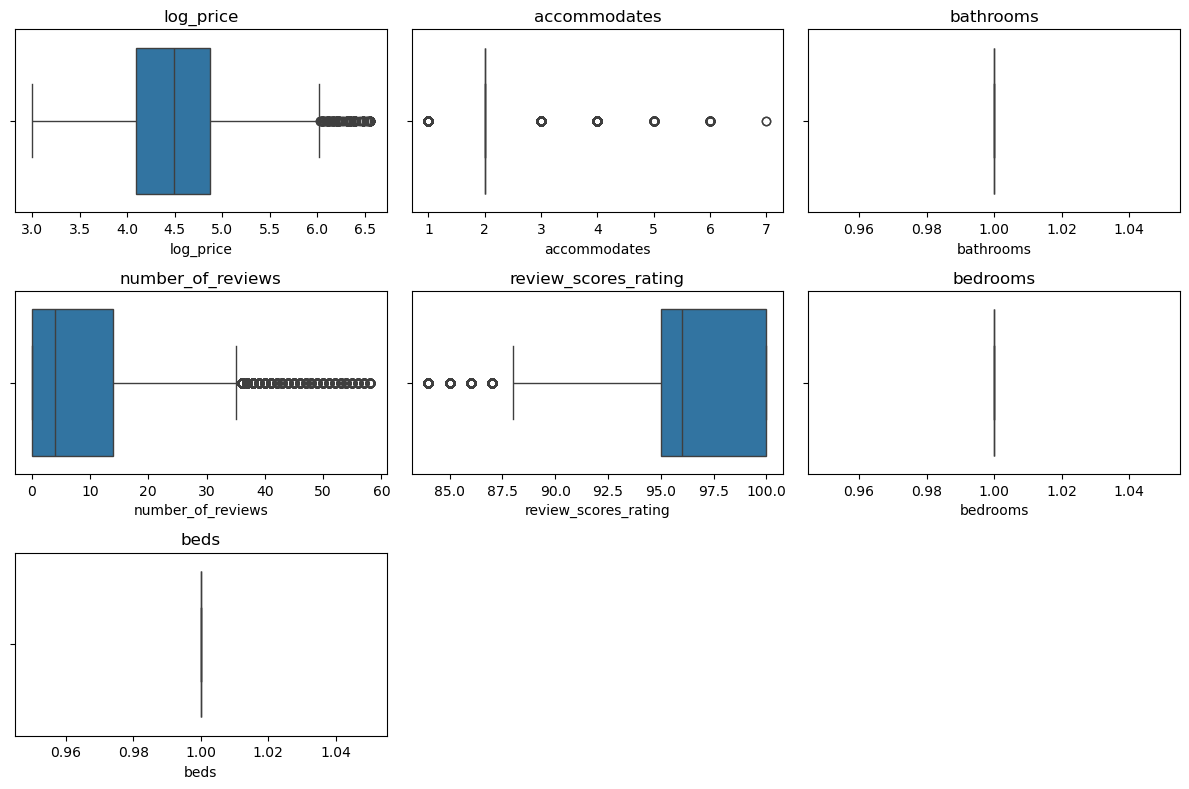

In [49]:
# Boxplot for outliers
num_cols = ["log_price", "accommodates", "bathrooms", "number_of_reviews", "review_scores_rating", "bedrooms", "beds"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [19]:
#  Removing outliers (IQR method)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in num_cols:
    df = remove_outliers(df, col)

### Feature Engineering: Extract meaningful features, such as neighborhood popularity, number of amenities, and host activity metrics.

In [21]:
# Feature Engineering
df["amenities_count"] = df["amenities"].apply(lambda x: len(str(x).split(",")))
df["host_days_active"] = (pd.to_datetime("today") - pd.to_datetime(df["host_since"])).dt.days
df["neighborhood_popularity"] = df.groupby("neighbourhood")["id"].transform("count")

In [23]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'amenities_count', 'host_days_active', 'neighborhood_popularity'],
      dtype='object')

In [25]:
#Converting Categorical Features to Numerical using Label Encoding
categorical_features = ["property_type", "room_type", "city","number_of_reviews","amenities","neighbourhood","bed_type",
                       "host_days_active"]
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [27]:
# Creating a new dataframe with encoded values and log_price
df_cleaned = df[categorical_features + ["log_price"]]

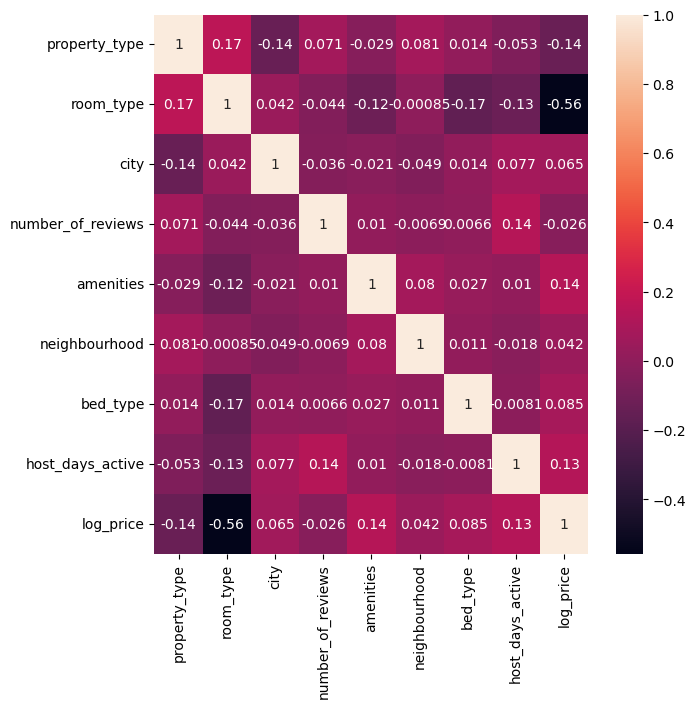

In [29]:
## checking for correlation among the dependent and independent variables
corr=df_cleaned.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr,annot=True)
plt.rc('ytick',labelsize=8)
plt.show()

### Data Splitting: Divide the data into training, validation, and testing sets to ensure robust evaluation.

In [31]:
# Splitting data into train, validation, and test sets
X = df.drop(columns=["log_price", "id", "name", "description", "first_review", "last_review", "thumbnail_url", 
                     "zipcode","bed_type","cancellation_policy","bathrooms","cleaning_fee","host_has_profile_pic","host_identity_verified",
                     "instant_bookable","latitude","longitude","beds","host_days_active","host_response_rate","host_since","host_days_active",
                     "accommodates","review_scores_rating","bedrooms"
])
y = df["log_price"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:
## verfiying columns inside X
X.columns

Index(['property_type', 'room_type', 'amenities', 'city', 'neighbourhood',
       'number_of_reviews', 'amenities_count', 'neighborhood_popularity'],
      dtype='object')

### Model Tuning: Experiment with different models and tune hyperparameters to optimize performance.

In [35]:
# Model Training and Hyperparameter Tuning
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="r2")

In [37]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [39]:
best_model = grid_search.best_estimator_

In [41]:
# Model Evaluation
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}, R²: {r2}")

RMSE: 0.39288920496364865, MAE: 0.2977592930648102, R²: 0.4964344512780794


### Visualizations: Use charts and graphs to present data trends and model results clearly.

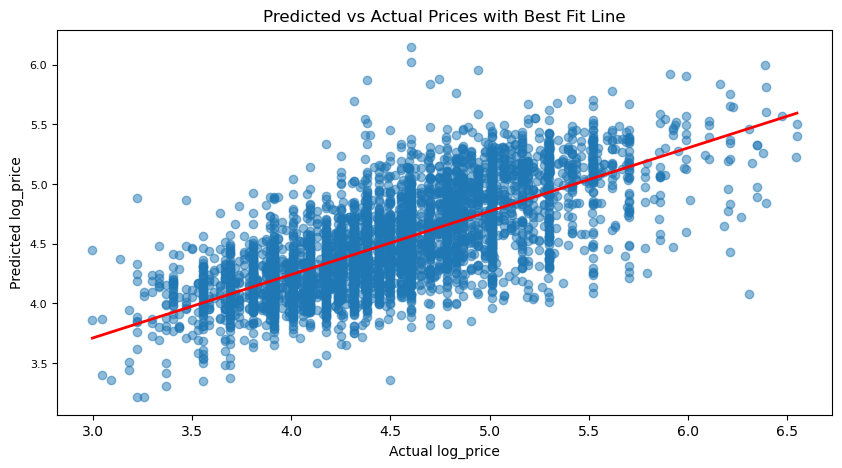

In [43]:
plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.5}, line_kws={'color': 'red', 'linewidth': 2})
plt.xlabel("Actual log_price")
plt.ylabel("Predicted log_price")
plt.title("Predicted vs Actual Prices with Best Fit Line")
plt.show()

###  Interpretability: Ensure the model is interpretable and actionable for non-technical stakeholders.

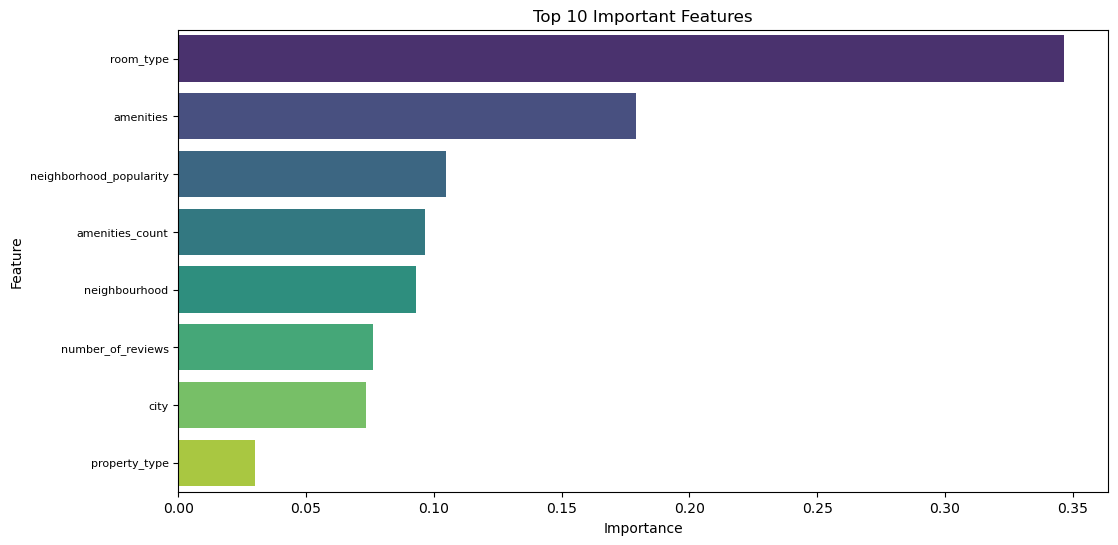

In [51]:
# Feature importance
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": best_model.feature_importances_})
feature_importances.sort_values(by="Importance", ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances.head(10),palette='viridis')
plt.title("Top 10 Important Features")
plt.show()

### ### video link
Note: Sorry for the bad quality since i was having an electicity shortage in our area.

In [ ]:
### video link
https://drive.google.com/file/d/1ePW76RTo5ELoaSXEpUHtGSA9aMo9lOyg/view?usp=sharing